In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os 
import wave
from PIL import Image
from tensorflow.keras.applications.resnet50 import preprocess_input
from io import BytesIO
from scipy.io import wavfile
from scipy.signal import spectrogram

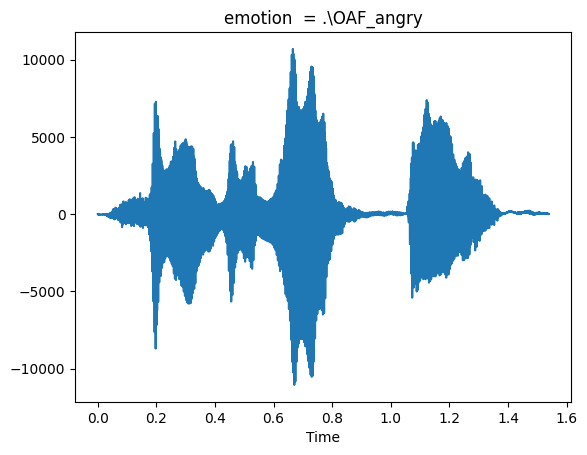

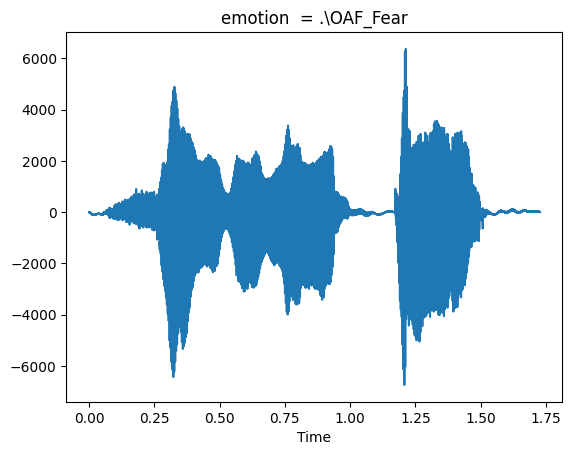

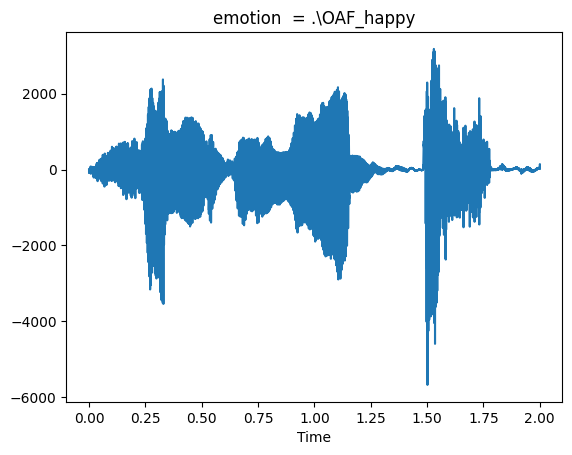

In [33]:

for root, dirs, files in os.walk('.'):
    if root not in [".\OAF_angry", ".\OAF_happy", ".\OAF_Fear"]:    
        continue
     
    for file in files[:1]:
        raw = wave.open(os.path.join(root, file))


        signal = raw.readframes(-1) 
        signal = np.frombuffer(signal, dtype ="int16") 
        
        # gets the frame rate 
        f_rate = raw.getframerate() 

        time = np.linspace( 
            0, # start 
            len(signal) / f_rate, 
            num = len(signal) 
        ) 

   
        # creates a new figure 
        plt.figure(1) 
        
        # title of the plot 
        plt.title(f"emotion  = {root}") 
        
        # label of x-axis 
        plt.xlabel("Time") 
        
        # actual plotting 
        plt.plot(time, signal) 
        
        # shows the plot  
        # in new window 
        plt.show() 


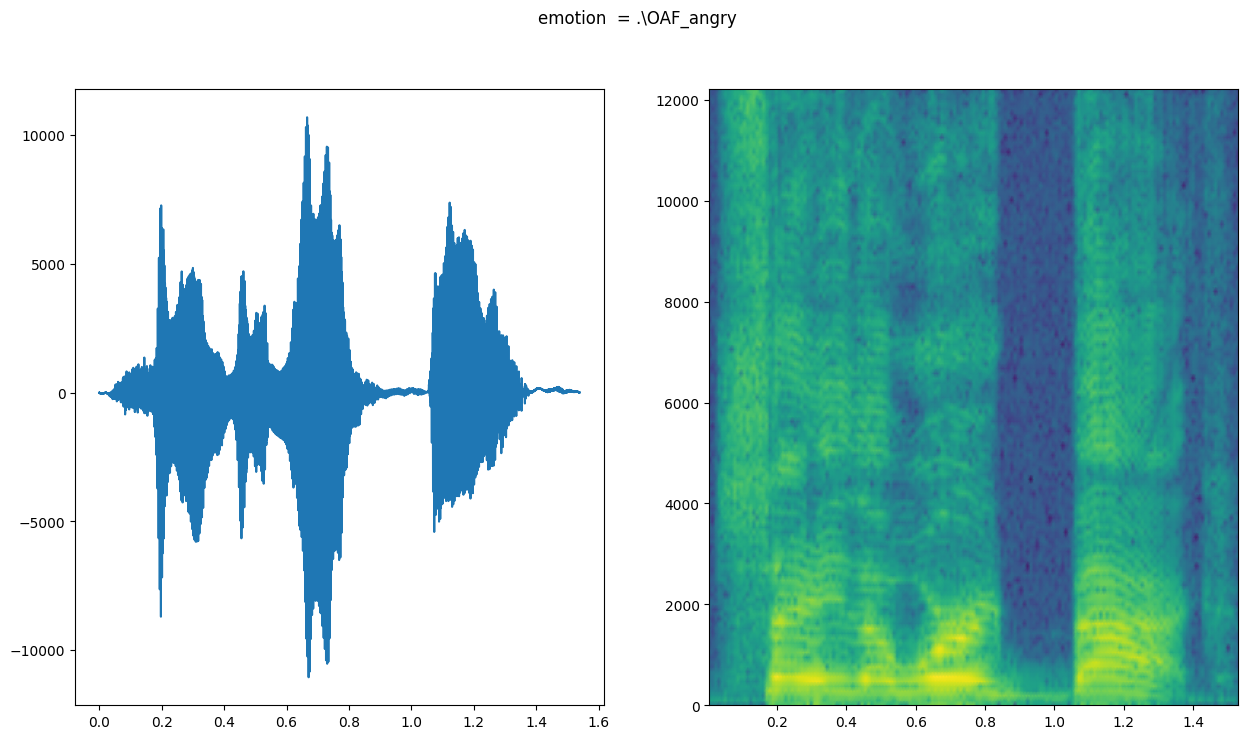

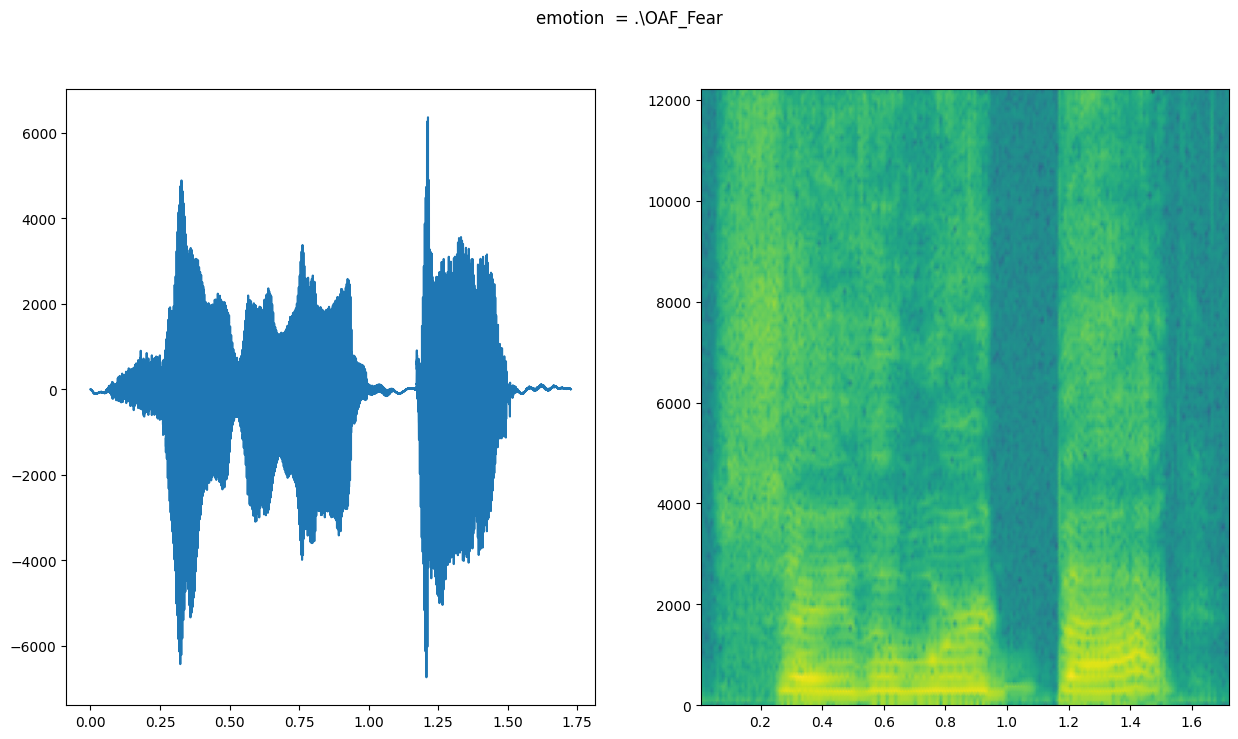

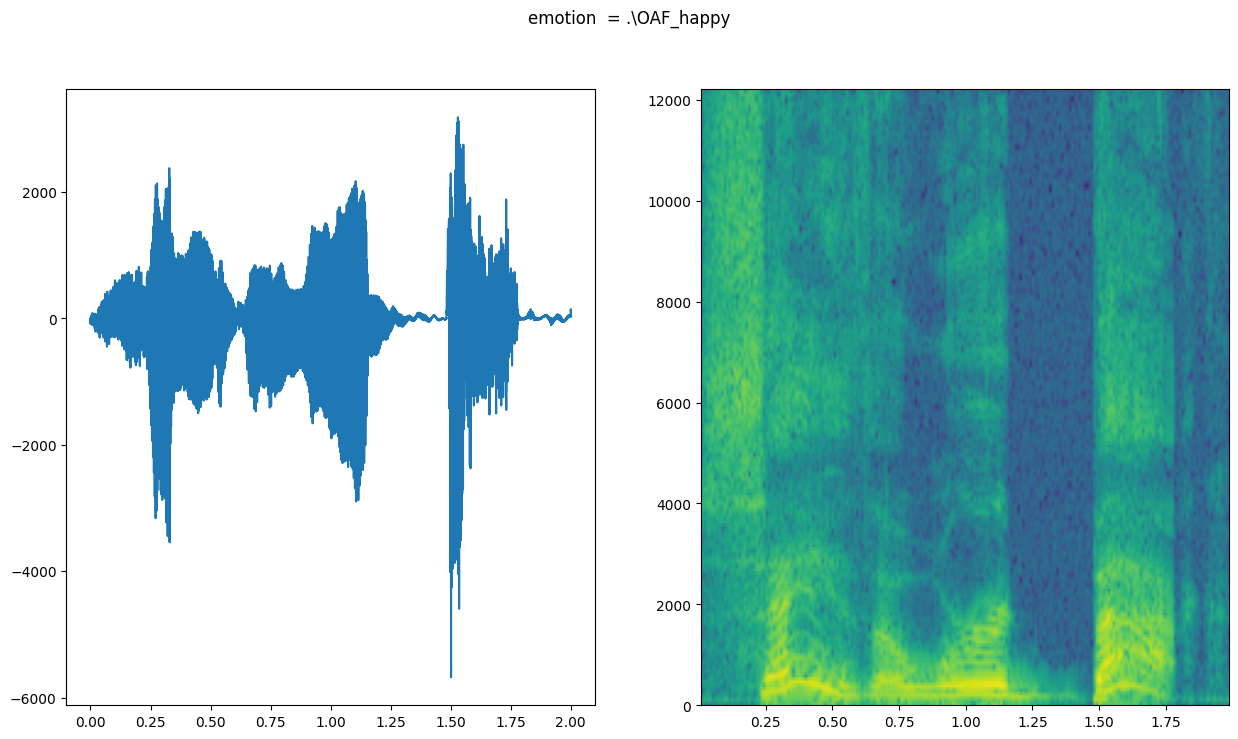

In [54]:

for root, dirs, files in os.walk('.'):
    if root not in [".\OAF_angry", ".\OAF_happy", ".\OAF_Fear"]:    
        continue
     
    for file in files[:1]:
        plt.rcParams['figure.figsize'] = [15, 8]
        raw = wave.open(os.path.join(root, file))


        signal = raw.readframes(-1) 
        signal = np.frombuffer(signal, dtype ="int16") 
        
        # gets the frame rate 
        f_rate = raw.getframerate() 

        time = np.linspace( 
            0, # start 
            len(signal) / f_rate, 
            num = len(signal) 
        ) 

        # spectogram
        sample_rate, samples = wavfile.read(os.path.join(root, file))
        f, t, Sxx = spectrogram(samples, fs=sample_rate)
        
    


        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.suptitle(f"emotion  = {root}")
        ax1.plot(time, signal)
        ax2.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
        
        plt.show()


### CREATING THE IMAGES FOR CNN

In [23]:


def save_spectrogram(input_path, output_path):
    sample_rate, samples = wavfile.read(input_path)
    f, t, Sxx = spectrogram(samples, fs=sample_rate)
    
    fig = plt.figure()
    plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
    
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.savefig(output_path, format='png', bbox_inches='tight', pad_inches=0)
    plt.close(fig) 

In [24]:
for root, dirs, files in os.walk('.'):
    if root == '.':
        continue

    os.makedirs(root+"_images", exist_ok=True) # her duygu için yeni bir klasör açıyoruz.
    for file in files:
        save_spectrogram(os.path.join(root, file), os.path.join(root+"_images", file.split(".")[0]+".png"))
    

In [62]:

### RESNET50 PREPROCESSING ###
# 224 x 224 boyutunda ve RGB formatında input bekliyor.
image_size = (224, 224) 
image_data = []
labels = []

for root, dirs, files in os.walk('.'):
    if not root.endswith('_images'):
        continue

    label = os.path.basename(root).replace('_images', '')

    for file in files:
        if not file.endswith('.png'):
            continue

        img_path = os.path.join(root, file)

      
        img = Image.open(img_path).convert('RGB')
        img = img.resize(image_size)
        img_array = np.array(img).astype('float32')

        # Preprocess for ResNet50
        img_array = preprocess_input(img_array)

        image_data.append(img_array)
        labels.append(label)

X = np.array(image_data)
y = np.array(labels)

print("X shape:", X.shape)  # (num_samples, 224, 224, 3 (rgb input))
print("y shape:", y.shape)


X shape: (600, 224, 224, 3)
y shape: (600,)


In [63]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_onehot = to_categorical(y_encoded)


base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(y_onehot.shape[1], activation='softmax')(x)

tf_model = Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers:
    layer.trainable = False

# Compile
tf_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [64]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y_onehot, 
    test_size=0.2,      
    random_state=42)  


In [65]:
history = tf_model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=1
)



Epoch 1/10
15/15 [==============================] - 26s 2s/step - loss: 0.8698 - accuracy: 0.6313 - val_loss: 0.3728 - val_accuracy: 0.9333
Epoch 2/10
15/15 [==============================] - 20s 1s/step - loss: 0.2210 - accuracy: 0.9729 - val_loss: 0.1651 - val_accuracy: 0.9833
Epoch 3/10
15/15 [==============================] - 20s 1s/step - loss: 0.1168 - accuracy: 0.9854 - val_loss: 0.1110 - val_accuracy: 0.9917
Epoch 4/10
15/15 [==============================] - 20s 1s/step - loss: 0.0880 - accuracy: 0.9875 - val_loss: 0.0916 - val_accuracy: 0.9917
Epoch 5/10
15/15 [==============================] - 20s 1s/step - loss: 0.0625 - accuracy: 0.9937 - val_loss: 0.0605 - val_accuracy: 1.0000
Epoch 6/10
15/15 [==============================] - 22s 1s/step - loss: 0.0484 - accuracy: 0.9896 - val_loss: 0.0621 - val_accuracy: 1.0000
Epoch 7/10
15/15 [==============================] - 20s 1s/step - loss: 0.0353 - accuracy: 0.9937 - val_loss: 0.0551 - val_accuracy: 1.0000
Epoch 8/10
15/15 [==

### CREATING NEW TEST DATA WITH LLM

In [79]:
from transformers import AutoProcessor, AutoModel,pipeline,BarkModel
import scipy
import numpy as np 

processor = AutoProcessor.from_pretrained("suno/bark")
model = BarkModel.from_pretrained("suno/bark")
text = "Nice to meet you .[laughter]"

inputs = processor(text, voice_preset="v2/en_speaker_6")
audio_array = model.generate(**inputs)
audio_array = audio_array.cpu().numpy().squeeze()
sample_rate = model.generation_config.sample_rate
scipy.io.wavfile.write("bark_out.wav",rate=sample_rate, data=audio_array)


KeyboardInterrupt: 

In [ ]:
##multi language çalışmıyor.
processor = AutoProcessor.from_pretrained("suno/bark")
model = BarkModel.from_pretrained("suno/bark")
text = "[angry] Basta. No más excusas. Terminé con esto. [angry]"

inputs = processor(text, voice_preset="v2/es_speaker_4")
audio_array = model.generate(**inputs,pad_token_id=model.config.eos_token_id)
audio_array = audio_array.cpu().numpy().squeeze()
sample_rate = model.generation_config.sample_rate
scipy.io.wavfile.write("bark_out_es.wav",rate=sample_rate, data=audio_array)


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:10000 for open-end generation.


In [60]:
def preprocess_audio_input(input_path):
    image_size = (224, 224)  # ResNet50 input size
    # Read audio
    sample_rate, samples = wavfile.read(input_path)
    f, t, Sxx = spectrogram(samples, fs=sample_rate)

    # Plot spectrogram to an in-memory buffer
    fig = plt.figure(figsize=(2.24, 2.24), dpi=100)  # Optional: control size
    plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
    plt.axis('off')
    plt.tight_layout(pad=0)


    buf = BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)
    plt.close(fig)
    buf.seek(0)

    image = Image.open(buf).convert('RGB')
    img = image.resize(image_size)
    img_array = np.array(img).astype('float32')

        # Preprocess for ResNet50
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)  # Shape: (1, 224, 224, 3)

    return img_array  # Shape: (H, W, 3)

In [87]:
a = preprocess_audio_input("bark_out.wav")
le.inverse_transform([np.argmax(tf_model.predict(a))])

1/1 [==============================] - 0s 78ms/step


array(['OAF_happy'], dtype='<U9')

In [86]:
a = preprocess_audio_input("bark_out_es.wav")
le.inverse_transform([np.argmax(tf_model.predict(a))])

1/1 [==============================] - 0s 82ms/step


array(['OAF_Fear'], dtype='<U9')